In [ ]:
This notebook will illustrate how to process DICOM series using python. The two libraries should be installed:
1. opencv-python;
2. pydicom

anaconda show menpo/opencv3
conda install --channel https://conda.anaconda.org/menpo opencv3 #如果通过pip install和conda install同时安装有可能导致冲突
conda install -c conda-forge pydicom=0.9.9

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dicom as pdicom
import os
import glob

%matplotlib inline


In [3]:
import pandas as pd
import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [18]:
Dicom_folder = "C:\Personal\Medical_Deep_Learning\lung-data\肺部小结节薄层CT数据"
#Dicom_folder = "C:\Personal\Medical_Deep_Learning\Kaggle\dicom"
patients = os.listdir(Dicom_folder)
patients.sort()

In [5]:
def get_dicom_files(path):
    lstFilesDCM = []
    for dirname, subdirlist, filelist in os.walk(path):
        for filename in filelist:
            if ".dcm" in filename.lower():
                lstFilesDCM.append(os.path.join(dirname, filename))
    return lstFilesDCM

#patient_dcms=load_dcm(Dicom_folder)
#print(len(patient_dcms))

In [6]:
class DicomBasicInfo:
    #def __init__(self, manufa, model, protocol, name, paid, birthdate, sex, 
    #             slicethickness,scanlen):
    def __init__(self):
        self.Manufacturer = ''
        self.ManufacturerModelName = ''
        self.ProtocolName = ''
        self.PatientName = ''
        self.PatientID = ''
        self.PatientBirthDate = ''
        self.PatientSex = ''
        self.PixelSpacing = None
        self.SliceThickness = ''
        self.RescaleIntercept = ''
        self.RescaleSlope = ''
        self.RescaleType = ''

    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)

In [7]:
def getDicomMetaDataFieldValue(dcmdata, fieldname, defaultvalue = ''):
    val = defaultvalue
    if hasattr(dcmdata, fieldname):
        val = getattr(dcmdata,fieldname)
    return val

In [19]:
def getDicomMetaData(dcmdata):    
    dcmdata.decode()
    #print(dcmdata)
    
    basicinfo = DicomBasicInfo()
    #scanlen = getDicomMetaDataFieldValue(dcmdata, 'ScanLength', -1)
    basicinfo.Manufacturer = getDicomMetaDataFieldValue(dcmdata, 'Manufacturer')
    basicinfo.ManufacturerModelName = getDicomMetaDataFieldValue(dcmdata, 'ManufacturerModelName')
    basicinfo.ProtocolName = getDicomMetaDataFieldValue(dcmdata, 'ProtocolName')
    basicinfo.PatientName = getDicomMetaDataFieldValue(dcmdata, 'PatientName')
    basicinfo.PatientID = getDicomMetaDataFieldValue(dcmdata, 'PatientID')
    basicinfo.PatientBirthDate = getDicomMetaDataFieldValue(dcmdata, 'PatientBirthDate')
    basicinfo.PatientSex = getDicomMetaDataFieldValue(dcmdata, 'PatientSex')
    basicinfo.PixelSpacing = getDicomMetaDataFieldValue(dcmdata, 'PixelSpacing', None)
    basicinfo.SliceThickness = getDicomMetaDataFieldValue(dcmdata, 'SliceThickness', 0.0)
    basicinfo.RescaleIntercept = getDicomMetaDataFieldValue(dcmdata, 'RescaleIntercept')
    basicinfo.RescaleSlope = getDicomMetaDataFieldValue(dcmdata, 'RescaleSlope')
    basicinfo.RescaleType = getDicomMetaDataFieldValue(dcmdata, 'RescaleType')
    #print(vars(basicinfo))
    return basicinfo

def loadDicom(dcmfiles): #For one patient
    dcms = [pdicom.read_file(dcmfile) for dcmfile in dcmfiles]
    dcms.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    
    if not hasattr(dcms[0], 'SliceThickness'):
        try:
            slickthickness = np.abs(dcms[0].ImagePositionPatient[2] - dcms[1].ImagePositionPatient[2])
        except:
            slickthickness = np.abs(dcms[0].SliceLocation - dcms[1].SliceLocation)
        for dcm in dcms:
            dcm.SliceThickness = slickthickness
    return getDicomMetaData(dcms[0]), dcms

#for patient in patients:
#    patient_dcms=get_dicom_files(Dicom_folder + os.sep + patient)
#    getDicomMetaData(patient_dcms[0])
patient_dcms=get_dicom_files(Dicom_folder + os.sep + patients[0])
dicommeta, dcms = loadDicom(patient_dcms)
print(dicommeta)

<class '__main__.DicomBasicInfo'>: {'RescaleIntercept': '-1024', 'PatientID': 'ZS17019039', 'ProtocolName': 'Chest Helical', 'PatientName': 'BAO^CHIBO', 'Manufacturer': 'UIH', 'SliceThickness': '1', 'PatientBirthDate': '19740916', 'PixelSpacing': ['0.798828125', '0.798828125'], 'RescaleType': 'HU', 'PatientSex': 'M', 'ManufacturerModelName': 'uCT 760', 'RescaleSlope': '1'}


In [9]:
def getPixelsHu(dcms):
    image = np.stack([dcm.pixel_array for dcm in dcms])
    print(image.shape)
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for dcm_index in range(len(dcms)):
        
        intercept = dcms[dcm_index].RescaleIntercept
        slope = dcms[dcm_index].RescaleSlope
        
        if slope != 1:
            image[dcm_index] = slope * image[slice_number].astype(np.float64)
            image[dcm_index] = image[slice_number].astype(np.int16)
            
        image[dcm_index] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def displayHUStatistic(dcms):
    pixelhus = getPixelsHu(dcms)
    print(pixelhus.flatten())
    plt.hist(pixelhus.flatten(), bins='auto', color='c')
    plt.xlabel("Hounsfield Units (HU)")
    plt.ylabel("Frequency")
    plt.show()

    # Show some slice in the middle
    plt.imshow(pixelhus[80], cmap=plt.cm.gray)
    plt.show()

#displayHUStatistic(dcms)
pixelhus = getPixelsHu(dcms)

(134, 512, 512)


In [10]:
#Normalize the image to a common spacing
def nomalization(pixelhus, dcms, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([dcms[0].SliceThickness] + dcms[0].PixelSpacing, dtype=np.float32)
    print('current spacing: ',spacing)
    resize_factor = spacing / new_spacing
    print('spacing resize_factor: ', resize_factor)
    new_real_shape = pixelhus.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / pixelhus.shape
    print('real_resize_factor: ', real_resize_factor)
    new_spacing = spacing / real_resize_factor
    
    pixelhus = scipy.ndimage.interpolation.zoom(pixelhus, real_resize_factor, mode='nearest')
    
    return pixelhus, new_spacing

normalized_hu, spacing = nomalization(pixelhus, dcms, new_spacing=[1,1,1])
print(pixelhus.shape)
print(normalized_hu.shape)

current spacing:  [ 2.5         0.59765601  0.59765601]
spacing resize_factor:  [ 2.5         0.59765601  0.59765601]
real_resize_factor:  [ 2.5         0.59765625  0.59765625]
(134, 512, 512)
(335, 306, 306)


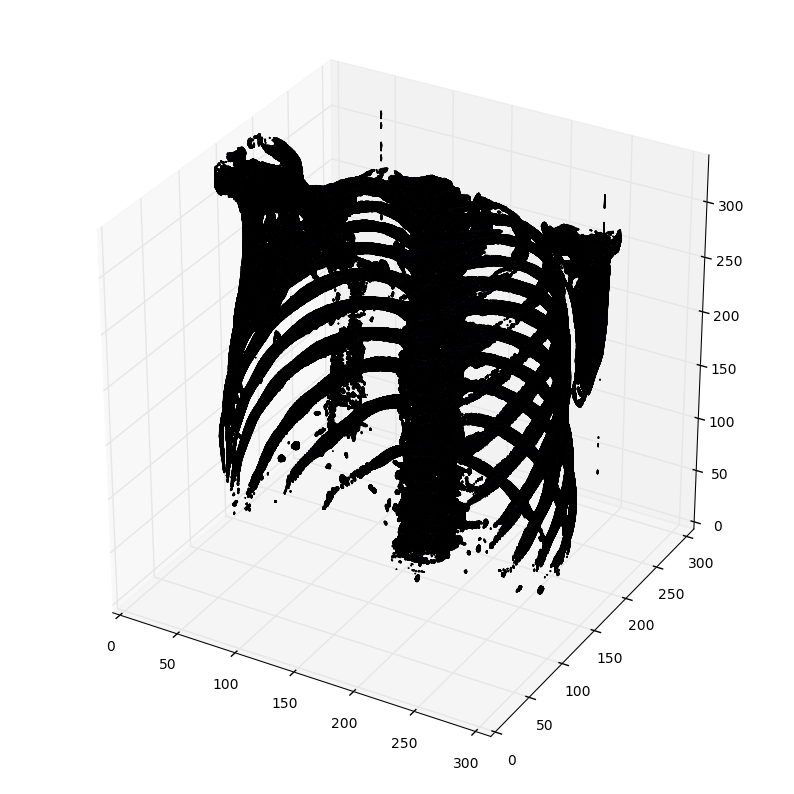

In [11]:
def display3DDicomImage(pixelhus, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = pixelhus.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

display3DDicomImage(normalized_hu, 400)

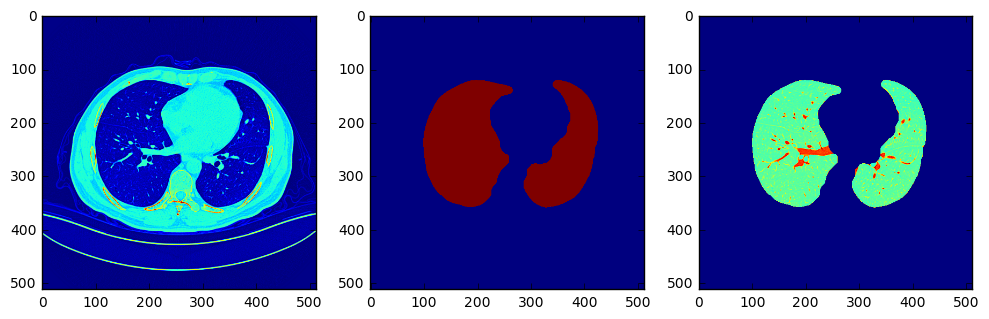

In [20]:
def rescaleDicom(dcm):
    dcm.image = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    
def segmentDicom(dcms):
    img = dcms[ int(len(dcms)/2) ].image.copy()

    # threshold HU > -300
    img[img>-300] = 255
    img[img<-300] = 0
    img = np.uint8(img)

    imgcopy = img.copy() # For opencv 3.1, doesn't need in 3.2
    # find surrounding torso from the threshold and make a mask
    im2, contours, _ = cv2.findContours(img,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    mask = np.zeros(img.shape, np.uint8)
    cv2.fillPoly(mask, [largest_contour], 255)

    img = imgcopy.copy() # For opencv 3.1, doesn't need in 3.2
    # apply mask to threshold image to remove outside. this is our new mask
    img = ~img
    img[(mask == 0)] = 0 # <-- Larger than threshold value

    # apply closing to the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15))
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)  # <- to remove speckles...
    img = cv2.morphologyEx(img, cv2.MORPH_DILATE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_DILATE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
    
    # apply mask to image
    img2 = dcms[ int(len(dcms)/2) ].image.copy()
    img2[(img == 0)] = -2000 # <-- Larger than threshold value

    # closing
    #sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    #largest_contour = max(contours, key=cv2.contourArea)
    #rgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    #aaa = np.concatenate( sorted_contours[1:3] )
    #cv2.drawContours(rgb, [cv2.convexHull(aaa)], -1, (0,255,0), 3)

    plt.figure(figsize=(12, 12))
    plt.subplot(131)
    plt.imshow(dcms[ int(len(dcms)/2) ].image)
    plt.subplot(132)
    plt.imshow(img)
    plt.subplot(133)
    plt.imshow(img2)
    plt.show()

for dcm in dcms:
    rescaleDicom(dcm)
segmentDicom(dcms)

In [ ]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
PIXEL_MEAN = 0.25
PIXEL_CORR = int((MAX_BOUND - MIN_BOUND) * PIXEL_MEAN) # in this case, 350

def zero_center(image):
    image = image - PIXEL_CORR
    return image

def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>(1-PIXEL_MEAN)] = 1.
    image[image<(0-PIXEL_MEAN)] = 0.
    return image

In [39]:
def process_patient_CT(parentdir, patient_name, display=False):
    #print("Processing ", patient_name, "......")
    patient_dcms=get_dicom_files(parentdir + os.sep + patient_name)
    #dcmdata = pdicom.read_file(patient_dcms[0])
    #print(dcmdata.Manufacturer)
    #print(dcmdata.ManufacturerModelName)
    #print(dcmdata.PatientName)
    #print(dcmdata.PatientID)
    #print(dcmdata.PatientBirthDate)
    #print(dcmdata.PatientSex)
    #print(dcmdata)
    #scanlen = -1
    #if hasattr(dcmdata, 'ScanLength'):
    #    #print(dcmdata.ScanLength)
    #    scanlen = int(dcmdata.ScanLength)
    #    if len(patient_dcms) != scanlen:
    #        print(patient_name, "  Actual dicom image number is not equal to the scan length!!!")
    
    
    if display == True:
        pixeldimens = (int(dcmdata.Rows), int(dcmdata.Columns), len(patient_dcms))
        x = np.arange(0.0, (pixeldimens[0] +  1)*dcmdata.PixelSpacing[0], dcmdata.PixelSpacing[0])
        y = np.arange(0.0, (pixeldimens[1] +  1)*dcmdata.PixelSpacing[1], dcmdata.PixelSpacing[1])
        pixelarray = np.zeros(pixeldimens, dtype=dcmdata.pixel_array.dtype)
        for dcmfile in patient_dcms:
            content = pdicom.read_file(dcmfile)
            pixelarray[:, :, patient_dcms.index(dcmfile)] = content.pixel_array
        plt.figure(dpi=1600)
        plt.axes().set_aspect('equal','datalim')
        plt.set_cmap(plt.gray())
        plt.pcolormesh(x,y,np.flipud(pixelarray[:, :, 120]))
    
    basicinfo = getDicomMetaData(patient_dcms[0])
    #basicinfo = DicomBasicInfo(dcmdata.Manufacturer, dcmdata.ManufacturerModelName, dcmdata.PatientName,
    #                          dcmdata.PatientID, dcmdata.PatientBirthDate, dcmdata.PatientSex, scanlen)
    #basicinfo = {'Manufacturer':dcmdata.Manufacturer, 'ManufacturerModelName':dcmdata.ManufacturerModelName, 
    #             'PatientName':dcmdata.PatientName, 'PatientID':dcmdata.PatientID, 
    #             'PatientBirthDate':dcmdata.PatientBirthDate, 'PatientSex':dcmdata.PatientSex, 
    #             'Rows':dcmdata.Rows, 'Columns':dcmdata.Columns,
    #             'PixelSpacingX':dcmdata.PixelSpacing[0], 'PixelSpacingY':dcmdata.PixelSpacing[1],
    #             'PixelSpacingZ':dcmdata.SliceThickness, 'ScanLength':scanlen}
    return {'name':patient_name, 'basicinfo':basicinfo, 'dicomdata':patient_dcms}

images = []
isdisplayed = False
for patient in patients:
    row = process_patient_CT(Dicom_folder, patient, isdisplayed)
    images.append(row)
    isdisplayed = False
    
images = pd.DataFrame(images)
#images.basicinfo.apply(pd.Series)
images_UIH = images[images.basicinfo.apply(lambda x: x.Manufacturer == 'UIH')]
images_SIEMENS = images[images.basicinfo.apply(lambda x: x.Manufacturer == 'SIEMENS')]
images_TOSHIBA = images[images.basicinfo.apply(lambda x: x.Manufacturer == 'TOSHIBA')]
images_GE = images[images.basicinfo.apply(lambda x: x.Manufacturer == 'GE MEDICAL SYSTEMS')]
#expand the dict column to multiple columns
#images = pd.concat([images.drop(['basicinfo'], axis=1), images['basicinfo'].apply(pd.Series)], axis=1)
#images.Manufacturer.unique()
#images_UIH = images[(images.Manufacturer == 'UIH')]
#images_SIEMENS = images[(images.Manufacturer == 'SIEMENS')]
#images_TOSHIBA = images[(images.Manufacturer == 'TOSHIBA')]
#images_GE = images[(images.Manufacturer == 'GE MEDICAL SYSTEMS')]
print('UIH:', len(images_UIH))
print('SIEMENS:', len(images_SIEMENS))
print('TOSHIBA:', len(images_TOSHIBA))
print('GE:', len(images_GE))

{'Manufacturer': 'UIH', 'PatientBirthDate': '19740916', 'PatientName': 'BAO^CHIBO', 'PatientSex': 'M', 'ManufacturerModelName': 'uCT 760', 'PatientID': 'ZS17019039', 'ProtocolName': 'Chest Helical', 'ScanLength': '390'}
{'Manufacturer': 'UIH', 'PatientBirthDate': '19780312', 'PatientName': 'BAO^JIANFENG', 'PatientSex': 'M', 'ManufacturerModelName': 'uCT 760', 'PatientID': 'ZS14235680', 'ProtocolName': 'Chest Helical', 'ScanLength': '345'}
{'Manufacturer': 'SIEMENS', 'PatientBirthDate': '19480530', 'PatientName': 'BEI^YUANCHENG', 'PatientSex': 'M', 'ManufacturerModelName': 'Emotion 16', 'PatientID': 'ZS17009588', 'ProtocolName': '1LungCARE', 'ScanLength': -1}
{'Manufacturer': 'SIEMENS', 'PatientBirthDate': '19611227', 'PatientName': 'CHEN^ASHUN', 'PatientSex': 'M', 'ManufacturerModelName': 'SOMATOM Definition AS+', 'PatientID': 'ZS16245904', 'ProtocolName': 'Lung_small_nodules', 'ScanLength': -1}
{'Manufacturer': 'UIH', 'PatientBirthDate': '19591016', 'PatientName': 'CHEN^JINDI', 'Patie

In [38]:
dcmdata = pdicom.read_file(patient_dcms[395])
#print(dcmdata)
pixeldimens = (dcmdata.Rows, dcmdata.Columns, len(patient_dcms))
pixelspacing = (float(dcmdata.PixelSpacing[0]), float(dcmdata.PixelSpacing[1]), float(dcmdata.SliceThickness))
dcmdata.pixel_array.shape

(512, 512)

In [21]:
arraydicom = np.zeros(pixeldimens, dcmdata.pixel_array.dtype)


(512, 512, 28959)

In [12]:
print(cv2.__version__)

3.1.0


Reference: https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial
           https://www.kaggle.com/armamut/getting-the-lungs-right